# Comparison YOLOv3 and trained model

-----

## Load packages

In [1]:
from core.model import (yolo_loss)
from core import utils
from core import config
from core import metrics

import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from tensorflow.keras import backend as K

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc
from IPython.display import display

In [2]:
print('tensorflow version:', tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.per_process_gpu_memory_fraction = 0.4

tensorflow version: 2.2.0-rc2


## Load models

In [3]:
# Load from h5 file
model_path = '/data/model/yolov3.h5'
yolov3_model = tf.keras.models.load_model(model_path, compile=False)

In [4]:
# Load from h5 file
model_path = 'save/model_trained.h5'
trained_model = tf.keras.models.load_model(model_path, compile=False)

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [6]:
metrics_poacher = [
    metrics.poacher_accuracy, 
    metrics.poacher_precision, 
    metrics.poacher_recall, 
    metrics.TP, 
    metrics.FP, 
    metrics.FN, 
    metrics.TN
]
yolov3_model.compile(optimizer=optimizer, 
                      loss={
                          'tf_op_layer_concat_4': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 52x52
                          'tf_op_layer_concat_7': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 26x26
                          'tf_op_layer_concat_10': lambda y_true, y_pred: yolo_loss(y_true, y_pred),# 13x13
                      },
                      metrics=metrics_poacher
                    )

trained_model.compile(optimizer=optimizer, 
                      loss={
                          'tf_op_layer_concat_4': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 52x52
                          'tf_op_layer_concat_7': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 26x26
                          'tf_op_layer_concat_10': lambda y_true, y_pred: yolo_loss(y_true, y_pred),# 13x13
                      },
                      metrics=metrics_poacher
                    )

In [7]:
gc.collect()

0

## Load data

In [8]:
frames_dir = '/data/train/'
labels_path = '/data/train_labels.csv'

In [9]:
labels = utils.load_labels(labels_path)

In [10]:
labels.shape

(316435, 7)

In [11]:
# Get all frames from a directory
frames_list = os.listdir(frames_dir)
frames_list = [f for f in frames_list if '(' not in f]

frames = [frames_dir + f for f in frames_list]

In [12]:
frames[:2]

['/data/train/1.2.5_48.jpg', '/data/train/1.1.1_1931.jpg']

In [13]:
print('There are %i images in the training set'% len(frames))

There are 60040 images in the training set


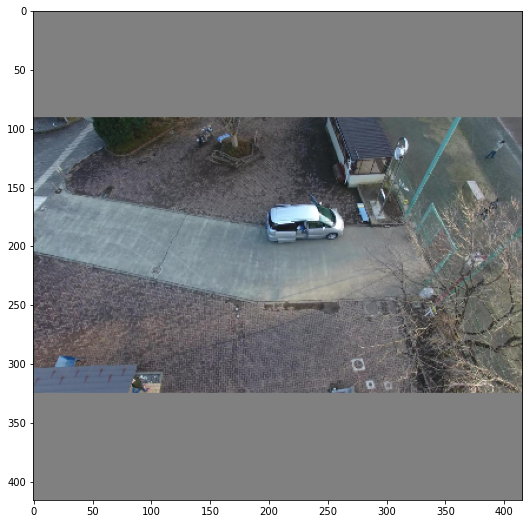

In [14]:
fig, ax = plt.subplots(figsize=(9,9))

frame = cv2.imread(frames[0])
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

# frame = cv2.resize(frame, (416,416))
frame = utils.image_preporcess(frame, (416,416))

plt.imshow(frame)
plt.show()

## Get frames with no person on it

In [14]:
n_frames_total = n_frames_pers = n_frames_no_pers = 0
frames_no_pers = []

for num_video in labels['video'].unique():
    frames_vid = labels[labels['video'] == num_video]['frame'].unique()
    frames_path_vid = [f for f in frames if num_video in f]
    
    frames_path = [f.split('_')[1][:-4] for f in frames_path_vid]
    cond = [int(f) not in frames_vid for f in frames_path]
    frames_path_no_pers = np.array(frames_path_vid)[cond].tolist()
    
    n_frames_total += len(frames_path_vid)
    n_frames_pers += len(frames_vid)
    n_frames_no_pers += len(frames_path_no_pers)
    frames_no_pers += frames_path_no_pers
    
#     print(num_video, len(frames_path_vid))

In [15]:
frames_pers = [f for f in frames if f not in frames_no_pers]

In [16]:
# len(frames_no_pers), len(frames_pers), len(frames)

In [17]:
print('There are %i videos.'%(labels['video'].nunique()))
print('For %i frames, %i contains persons in it and %i nothing'%(
    n_frames_total, n_frames_pers, n_frames_no_pers))
print('This is %.2f%% of frames with no persons'%(n_frames_no_pers * 100 / n_frames_total))

There are 33 videos.
For 65986 frames, 54356 contains persons in it and 7520 nothing
This is 11.40% of frames with no persons


In [18]:
gc.collect()

0

## Compare model prediction

41275 : /data/train/2.1.7_2509.jpg
Num person on frame: 1
Num person detected: 1
Num person detected: 2


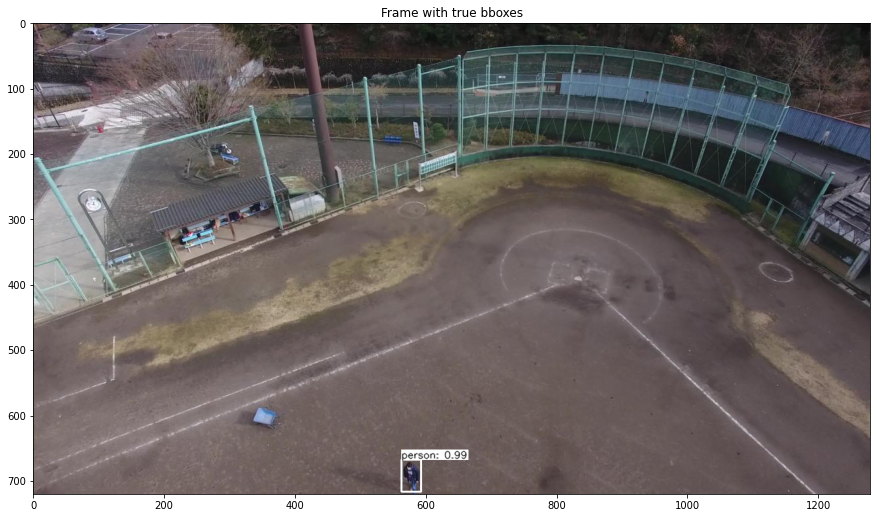

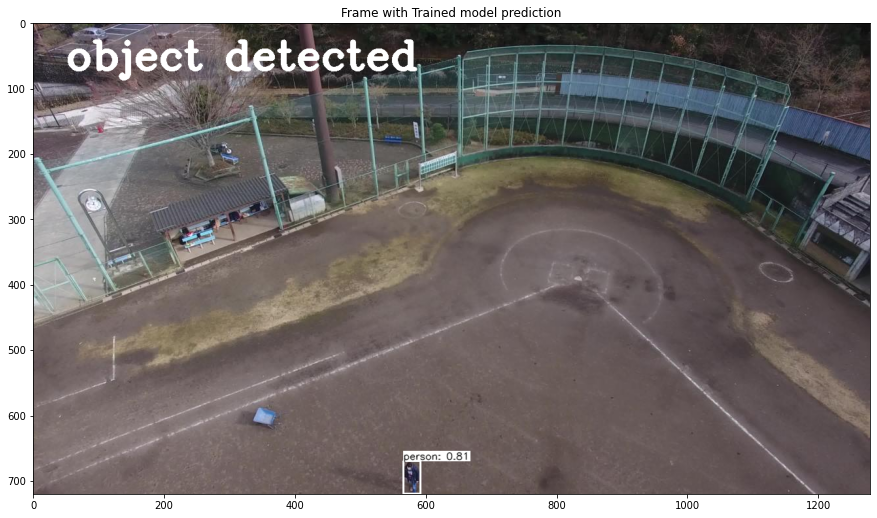

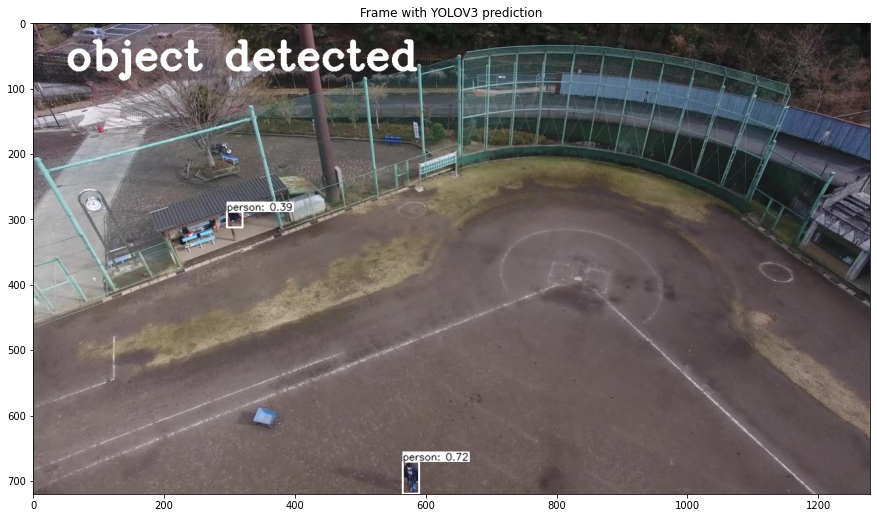

In [40]:
idx = np.random.randint(len(frames))
image_path2 = frames[idx]

# Use images with no person on it
if False:
    idx = np.random.randint(len(frames_no_pers))
    image_path2 = frames_no_pers[idx]
    
print(idx, ':', image_path2)

res = utils.frame_with_true_bboxes(image_path2, labels)
fig, ax = plt.subplots(figsize=(15,22))
plt.title('Frame with true bboxes')
plt.imshow(res)

frame = cv2.imread(image_path2)

out_new = utils.predict_on_frame(frame, trained_model, threshold=0.3)
fig, ax = plt.subplots(figsize=(15,22))
plt.title('Frame with Trained model prediction')
plt.imshow(out_new)

frame = cv2.imread(image_path2)
out_new = utils.predict_on_frame(frame, yolov3_model, threshold=0.3)
fig, ax = plt.subplots(figsize=(15,22))
plt.title('Frame with YOLOV3 prediction')
plt.imshow(out_new)
gc.collect()
plt.show()

## Compare scores

In [20]:
def load_batch_data(frames):
    """
    """
    n_batch = len(frames)

    Y_true = [np.zeros((n_batch, config.OUT_SIZE[i], config.OUT_SIZE[i], 3, (5+config.NUM_CLASS))) for i in range(3)]
    X = np.zeros(shape=(n_batch, config.INPUT_SIZE, config.INPUT_SIZE, 3), dtype=np.float32)

        
    for b in range(n_batch):
        if i == 0:
            np.random.shuffle(frames)
        image_data, image_target = utils.get_one_img_true_bboxes(frames[b], labels)

        X[b] = image_data

        for k in range(len(image_target)):
            Y_true[k][b] = image_target[k]

        gc.collect()
    
    return X, Y_true

In [21]:
def format_scores(scores):
    n = len(scores)
    scores_np = np.array(scores)[:,4:].reshape(n,3,-1)#.reshape(3,n,-1)
    l52 = scores_np[:,0]
    l26 = scores_np[:,1]
    l13 = scores_np[:,2]
    scores_np = np.array([l52, l26, l13])
    avg = np.round(np.nanmean(scores_np[:,:,:3], axis=1),2)
    sum = np.round(np.nansum(scores_np[:,:,3:], axis=1))
    scores_np = np.concatenate([avg, sum], axis=1)

    scores_df = pd.DataFrame(scores_np, 
                             columns=['accuracy','precision','recall','TP','FP','FN','TN'],
                             index=['layer 52x52','layer 26x26','layer 13x13'])
    return scores_df

In [22]:
np.random.seed(42)
np.random.shuffle(frames_pers)
np.random.shuffle(frames_no_pers)

# divisible by 2 !
n_sample = 250

frames_test = frames_pers[:n_sample]#.tolist()
frames_test += frames_no_pers[:n_sample]#.tolist()

In [23]:
scores_trained = list()
scores_yolov3 = list()

for i in tqdm(range(int(len(frames_test)/4))):
    X_valid, Y_valid = load_batch_data(frames_test[i*4:(i+1)*4])
    
    scores_trained.append(trained_model.evaluate(X_valid, Y_valid, verbose=0))
    
    scores_yolov3.append(yolov3_model.evaluate(X_valid, Y_valid, verbose=0))

    del X_valid, Y_valid
    gc.collect()

100%|██████████| 125/125 [06:08<00:00,  2.95s/it]


In [24]:
gc.collect()

0

In [25]:
scores_trained_df = format_scores(scores_trained)
scores_yolov3_df = format_scores(scores_yolov3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [26]:
print('SCORE TRAINED MODEL')
display(scores_trained_df)

print('SCORE YOLOV3 MODEL')
display(scores_yolov3_df)

SCORE TRAINED MODEL


,accuracy,precision,recall,TP,FP,FN,TN
layer 52x52,0.85,0.92,0.84,245.0,15.0,62.0,178.0
layer 26x26,0.99,0.20,0.25,1.0,4.0,3.0,492.0
layer 13x13,1.00,0.00,NaN,0.0,1.0,0.0,499.0


SCORE YOLOV3 MODEL


,accuracy,precision,recall,TP,FP,FN,TN
layer 52x52,0.77,0.93,0.68,203.0,9.0,104.0,184.0
layer 26x26,0.99,0.20,0.25,1.0,4.0,3.0,492.0
layer 13x13,1.00,0.00,NaN,0.0,1.0,0.0,499.0


## Compute inference time

In [27]:
def image_preporcess(image, target_size, gt_boxes=None):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

def get_image_preprocess(frame):

    input_size = config.INPUT_SIZE
    # Preprocess image (change size and convert to np array)
    frame_size = frame.shape[:2]
    image_data = image_preporcess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)

    gc.collect()
    return image_data

In [28]:
frame = cv2.imread(frames[0])
image_data = get_image_preprocess(frame)

In [29]:
def predict(X, model):
    t0 = time.time()
    pred = model.predict_on_batch(X)
    return pred, time.time() - t0

In [30]:
# Model warmup
pred, t = predict(image_data, trained_model)

In [31]:
print('first inference pred time %.2fs'%t)

first inference pred time 0.17s


In [32]:
# Compute average time
n_frames = 20
times = list()
preprocess_times = list()
img_times = list()

for i in tqdm(range(n_frames)):
    t0 = time.time()
    frame = cv2.imread(frames[i])
    img_times.append(time.time() - t0)
    
    t0 = time.time()
    image_data = get_image_preprocess(frame)
    preprocess_times.append(time.time() - t0)
    
    _, t = predict(image_data, trained_model)
    times.append(t)

100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


In [33]:
gc.collect()

0

In [34]:
print('Average inference load image time for %i images : %.2fs'%(n_frames, np.mean(img_times)))
print('Average inference preprocess time for %i images : %.2fs'%(n_frames, np.mean(preprocess_times)))
print('Average inference pred time for %i images : %.2fs'%(n_frames, np.mean(times)))

Average inference load image time for 20 images : 0.07s
Average inference preprocess time for 20 images : 0.18s
Average inference pred time for 20 images : 0.13s
